<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment9/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch**



# 1. Import library
<hr>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Load Data
<hr>

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

In [5]:
data_path = './MNIST'

training_set = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
testing_set = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
batch_32 = 32
batch_64 = 64
batch_128 = 128
learning_rate_value = 1e-3

In [7]:
train_loader_32 = DataLoader(dataset = training_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader_32 = DataLoader(dataset = testing_set, batch_size = batch_32, shuffle = True) ## batch size 32 짜리 test loader 생성

train_loader_64 = DataLoader(dataset = training_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 train loader 생성
test_loader_64 = DataLoader(dataset = testing_set, batch_size = batch_64, shuffle = True) ## batch size 64 짜리 test loader 생성

train_loader_128 = DataLoader(dataset = training_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 train loader 생성
test_loader_128 = DataLoader(dataset = testing_set, batch_size = batch_128, shuffle = True) ## batch size 128 짜리 test loader 생성


Target: 1


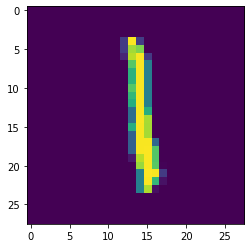

In [8]:
for X, Y in train_loader_32:
  plt.imshow(X[0][0].numpy())
  print(f"Target: {Y[0]}")
  break

# 3. Define Model
<hr>

In [9]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.Sigmoid(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.Sigmoid(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1),
        ) 
        
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


In [10]:
classifier = classification().to(device)

In [15]:
## Loss function
criterion = nn.NLLLoss()

# Optimization
optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value)